 # module name here

 > API details.

In [ ]:

import random
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter
import datetime
import pathlib
import os
import PIL
import torchvision
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import matplotlib.pyplot as plt
from transformers import BertModel, BertConfig, BertForSequenceClassification,DistilBertModel,DistilBertConfig,DistilBertForSequenceClassification

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import time
import re

In [ ]:
# from fastai2.tabular.all import *
# from fastai2.vision.all import *
# from fastai2.data.load import _FakeLoader, _loaders

seq_size =60
bs = 2
intermediate_size = 200
tabular_output_size=200
image_output_size = 200
num_attention_heads=10
path = "/home/marcel/projetos/data/csgo_analyze/processed_test/de_mirage"
embeds_size=image_output_size+tabular_output_size

def _get_files(p, fs, extensions=None):
    p = pathlib.Path(p)
    res = [p / f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res


def get_files(path_folder, extensions=None, recurse=True, folders=None, followlinks=True):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path_folder = pathlib.Path(path_folder)
    extensions = set(extensions)
    extensions = {e.lower() for e in extensions}
    folders = folders if not folders is None else []
    if recurse:
        res = []
        for i, (p, d, f) in enumerate(os.walk(path_folder, followlinks=followlinks)):  # returns (dirpath, dirnames, filenames)
            if len(folders) != 0 and i == 0:
                d[:] = [o for o in d if o in folders]
            else:
                d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) != 0 and i == 0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path_folder) if o.is_file()]
        res = _get_files(path_folder, f, extensions)
    return res



image_files = get_files(path, extensions=['.jpg'])
tabular_files = get_files(path, extensions=['.csv'])
print(len(image_files))
print(len(tabular_files))


renamed_files = 0
for path_image in image_files:
    new_path = re.sub(r'output_map(\d).jpg',r'output_map0\1.jpg', str(path_image))
    if new_path != str(path_image):
        os.rename(path_image,new_path)
        renamed_files+=1

if renamed_files >0:
    image_files = get_files(path, extensions=['.jpg'])
    tabular_files = get_files(path, extensions=['.csv'])
    print(len(image_files))
    print(len(tabular_files))



def fileLabeller(o, **kwargs):
    winnerFile = pathlib.Path(o).parent / "winner.txt"
    if os.path.isfile(winnerFile):
        f = open(winnerFile, "r")
        winner = f.readline()
        f.close()
    else:
        winner = "na"
    return winner


print(image_files[0])
print(fileLabeller(image_files[0]))

columns = ["t_1", "t_2", "t_3", "t_4", "t_5", "ct_1", "ct_2", "ct_3", "ct_4", "ct_5",
           "t_1_blindtime", "t_2_blindtime", "t_3_blindtime", "t_4_blindtime", "t_5_blindtime",
           "ct_1_blindtime", "ct_2_blindtime", "ct_3_blindtime", "ct_4_blindtime", "ct_5_blindtime",
           "t_1_mainweapon", "t_1_secweapon", "t_1_flashbangs", "t_1_hassmoke", "t_1_hasmolotov", "t_1_hashe",
           "t_1_armor", "t_1_hashelmet", "t_1_hasc4",
           "t_2_mainweapon", "t_2_secweapon", "t_2_flashbangs", "t_2_hassmoke", "t_2_hasmolotov", "t_2_hashe",
           "t_2_armor", "t_2_hashelmet", "t_2_hasc4",
           "t_3_mainweapon", "t_3_secweapon", "t_3_flashbangs", "t_3_hassmoke", "t_3_hasmolotov", "t_3_hashe",
           "t_3_armor", "t_3_hashelmet", "t_3_hasc4",
           "t_4_mainweapon", "t_4_secweapon", "t_4_flashbangs", "t_4_hassmoke", "t_4_hasmolotov", "t_4_hashe",
           "t_4_armor", "t_4_hashelmet", "t_4_hasc4",
           "t_5_mainweapon", "t_5_secweapon", "t_5_flashbangs", "t_5_hassmoke", "t_5_hasmolotov", "t_5_hashe",
           "t_5_armor", "t_5_hashelmet", "t_5_hasc4",
           "ct_1_mainweapon", "ct_1_secweapon", "ct_1_flashbangs", "ct_1_hassmoke", "ct_1_hasmolotov", "ct_1_hashe",
           "ct_1_armor", "ct_1_hashelmet", "ct_1_hasdefusekit",
           "ct_2_mainweapon", "ct_2_secweapon", "ct_2_flashbangs", "ct_2_hassmoke", "ct_2_hasmolotov", "ct_2_hashe",
           "ct_2_armor", "ct_2_hashelmet", "ct_2_hasdefusekit",
           "ct_3_mainweapon", "ct_3_secweapon", "ct_3_flashbangs", "ct_3_hassmoke", "ct_3_hasmolotov", "ct_3_hashe",
           "ct_3_armor", "ct_3_hashelmet", "ct_3_hasdefusekit",
           "ct_4_mainweapon", "ct_4_secweapon", "ct_4_flashbangs", "ct_4_hassmoke", "ct_4_hasmolotov", "ct_4_hashe",
           "ct_4_armor", "ct_4_hashelmet", "ct_4_hasdefusekit",
           "ct_5_mainweapon", "ct_5_secweapon", "ct_5_flashbangs", "ct_5_hassmoke", "ct_5_hasmolotov", "ct_5_hashe",
           "ct_5_armor", "ct_5_hashelmet", "ct_5_hasdefusekit",
           "round_time",
           'related_image', 'winner']

full_csv = []
round_winners = {}
for i, tab_file in enumerate(tabular_files):
    if i % 50 == 0:
        print("processing file:", i, "of", len(tabular_files))
    if not os.stat(tab_file).st_size == 0 and os.path.isfile(tab_file.parent / "winner.txt"):
        new_csv = pd.read_csv(tab_file)
        new_csv['index'] = new_csv.index
        new_csv['related_image'] = str(tab_file.parent) + "/output_map" + new_csv['index'].astype(str).str.pad(width=2,
                                                                                                               fillchar="0") + ".jpg"
        winner = fileLabeller(tab_file)
        new_csv['winner'] = winner
        round_winners[tab_file] = winner
        new_csv = new_csv.drop(columns=["index"])
        new_csv.columns = columns
        full_csv.append(new_csv)

full_csv = pd.concat(full_csv,ignore_index=True)
filtered_image_files = []
for image_file in image_files:
    if fileLabeller(image_file) in ["t", "ct"] and not os.stat(image_file.parent / "tabular.csv").st_size == 0 and \
            str(image_file) in full_csv['related_image'].values:
        filtered_image_files.append(image_file)
    #else: print(image_file)


def randomSplitter(elements, valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    if seed is not None: torch.manual_seed(seed)
    rand_idx = [int(i) for i in torch.randperm(len(elements))]
    cut = int(valid_pct * len(elements))
    return rand_idx[cut:], rand_idx[:cut]


def roundSplitter(filtered_image_files):
    uniqueList = list(set([pathlib.Path(o).parent for o in filtered_image_files]))
    splits = randomSplitter(uniqueList)
    train_image_files = []
    valid_image_files = []
    for i, o in enumerate(filtered_image_files):
        if uniqueList.index(pathlib.Path(o).parent) in splits[0]:
            train_image_files += [i]
        else:
            valid_image_files += [i]
    return train_image_files, valid_image_files


filtered_image_files.sort()
full_csv = full_csv.sort_values(by=['related_image'])
# filtered_image_files=filtered_image_files[:2000]
# full_csv=full_csv.iloc[:2000,:]
splits = roundSplitter(filtered_image_files)

print(filtered_image_files[55])
full_csv.iloc[55, :]

# class groups:
# mainweapon, secweapon,flashbangs,hassmoke,hasmolotov,hashe,hashelmet,hasc4,hasdefusekit

x_category_map = {"mainweapon": [0, 101, 102, 103, 104, 105, 106, 107,
                                 201, 202, 203, 204, 205, 206,
                                 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311],
                  "secweapon": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  "flashbangs": [0, 1, 2],
                  "hassmoke": [0, 1],
                  "hasmolotov": [0, 1],
                  "hashe": [0, 1],
                  "hashelmet": [0, 1],
                  "hasc4": [0, 1],
                  "hasdefusekit": [0, 1]}

y_category_map = {"winner": ["t", "ct"]}


def ToTensor(o):
    return torch.from_numpy(o)



class Categorize():
    def __init__(self, category_map: list = None, ordered_category_names = None,multicat=True):
        self.category_map = category_map
        self.multicat = multicat
        self.ordered_category_names=ordered_category_names



    def __call__(self, df_subset: pd.DataFrame):
        categories = []
        if self.multicat:
            for i, df_row in df_subset.iterrows():
                row_categories = []
                for cat in df_subset.columns:
                    group = cat[cat.rfind("_") + 1:]
                    category = self.category_map[group].index(df_row[cat])
                    row_categories.append(category)
                categories.append(row_categories)
        else:
            category = self.category_map["winner"].index(df_subset)
            categories.append(category)
        return np.array(categories)

    def decode(self,in_ndarray):
        ret_array = np.empty_like(in_ndarray)

        if self.multicat:
            for i in range(len(in_ndarray)):
                for j in range(len(in_ndarray[0])):
                    ret_array[i,j] = self.decode_element(in_ndarray[i,j],self.ordered_category_names[j])

        else:
            ret_array[0] = self.category_map["winner"][in_ndarray]

        return ret_array


    def decode_element(self,element,category):
        group = category[category.rfind("_") + 1:]
        return self.category_map[group][element]



class Normalize():
    def __init__(self, tabular_df: pd.DataFrame, category_map):
        self.means = [tabular_df[column].mean() for column in tabular_df.columns
                      if not column[column.rfind("_") + 1:] in category_map]
        self.std = [tabular_df[column].std() for column in tabular_df.columns
                    if not column[column.rfind("_") + 1:] in category_map]

    def __call__(self, o: pd.DataFrame):
        ret = o.copy()
        for i, column in enumerate(ret.columns):
            ret[column] = (o[column] - self.means[i]) / self.std[i]
        return ret.astype("float32").values

    def decode(self,o:pd.DataFrame):
        ret = o.copy()
        for i, column in enumerate(ret.columns):
            ret[column] = (o[column]*self.std[i] + self.means[i])

        return ret


class TransformPipeline():
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, o):
        res = o

        for transform in self.transforms:
            res = transform(res)

        return res
    def decode(self,o):
        res = o
        for i, transform in reversed(list(enumerate(self.transforms))):
            res = transform(res)
        return res


def calcNormWeights(imageList):
    means = [0., 0., 0.]
    std = [0., 0., 0.]
    resize = torchvision.transforms.Resize(200)
    to_tensor = torchvision.transforms.ToTensor()
    for j, imagePath in enumerate(imageList):
        image = to_tensor(resize(PIL.Image.open(imagePath)))
        if j % 50 == 0:
            print("processing image", j, "of", len(imageList))
        for i in range(3):
            means[i] += image[:, :, i].mean()
    for i in range(3):
        means[i] = means[i] / len(imageList)

    for j, imagePath in enumerate(imageList):
        if j % 50 == 0:
            print("processing image", j, "of", len(imageList))
        image = to_tensor(resize(PIL.Image.open(imagePath)))
        for i in range(3):
            std[i] += ((image[:, :, i] - means[i]) ** 2).mean()

    for i in range(3):
        std[i] = np.sqrt(std[i] / len(imageList))

    return means, std


# print(calcNormWeights(filtered_image_files))
# resizes 200, only mirage
# means:[tensor(0.0019), tensor(0.0040), tensor(0.0061)]
# std:[tensor(0.0043), tensor(0.0084), tensor(0.0124)]

class NormalizeImage():
    def __init__(self,mean,std):
        self.mean=mean
        self.std=std

    def __call__(self,tensor):

        return torch.stack([(tensor[:,i,:,:]-self.mean[i])/self.std[i] for i in range(3)],dim=1)

    def decode(self,tensor):
        return torch.stack([(tensor[:, i, :, :]*self.std[i] + self.mean[i]) for i in range(3)], dim=1)



class CSGORoundsDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths: list, round_paths: list, tabular_x_data: pd.DataFrame, round_winners,
                 image_transform=None, cat_transform=None,
                 cont_transform=None, label_transform=None, x_category_map: dict = None, y_category_map: dict = None,batch_transform=None):

        self.image_paths = image_paths
        cat_columns = [column for column in tabular_x_data.columns if column[column.rfind("_") + 1:] in x_category_map]
        cont_columns = [column for column in tabular_x_data.columns if
                        not column[column.rfind("_") + 1:] in x_category_map]
        self.cat_data = tabular_x_data[cat_columns]
        self.cont_data = tabular_x_data[cont_columns]
        self.y = round_winners
        self.x_round_list = round_paths
        self.n_samples = len(self.x_round_list)
        self.image_transform = image_transform
        self.cat_transform = cat_transform
        self.cont_transform = cont_transform
        self.label_transform = label_transform
        self.x_category_map = x_category_map
        self.y_category_map = y_category_map
        self.batch_transform = batch_transform

    def __getitem__(self, index: int):
        round_path = self.x_round_list[index]
        indices = [i for i, path_match in enumerate(self.image_paths)
                   if pathlib.Path(path_match).parent == round_path]

        inner_size = random.randint(2, len(indices))
        print("round:",round_path,"size:",inner_size)
        indices = indices[:inner_size]
        transform_times = []
        transform_times.append(time.time())
        images = self.open_round_images(indices)
        transform_times.append(time.time())
        if not self.image_transform is None:
            tensor_image = torch.stack([self.image_transform(image) for image in images], dim=0)
            transform_times.append(time.time())
            tensor_image = self.batch_transform(tensor_image)
            transform_times.append(time.time())
        if not self.cat_transform is None:
            cat_data = self.cat_transform(self.cat_data.iloc[indices, :])

        if not self.cont_transform is None:

            cont_data = self.cont_transform(self.cont_data.iloc[indices, :])

        if not self.label_transform is None:

            y = self.label_transform(self.y[round_path])

        #print(np.diff(np.array(transform_times)))
        return cat_data, cont_data, tensor_image, y,inner_size

    def __len__(self):
        return self.n_samples

    def open_round_images(self, indices):
        image_paths = [path_match for i, path_match in enumerate(self.image_paths) if i in indices]
        images = [PIL.Image.open(image_path) for image_path in image_paths]
        return images


def get_rounds_and_winners(tabular_df: pd.DataFrame):
    rounds = []
    winners = {}
    for index, row in tabular_df.iterrows():
        round_path = pathlib.Path(row['related_image']).parent
        rounds.append(round_path)
        winners[round_path] = row['winner']
    return list(set(rounds)), winners


train_tabular = full_csv.iloc[splits[0], :]
train_rounds, train_winners = get_rounds_and_winners(train_tabular)
train_images = [image for i, image in enumerate(filtered_image_files) if i in splits[0]]

valid_tabular = full_csv.iloc[splits[1], :]
valid_rounds, valid_winners = get_rounds_and_winners(valid_tabular)
valid_images = [image for i, image in enumerate(filtered_image_files) if i in splits[1]]

cat_transforms = TransformPipeline([Categorize(x_category_map), ToTensor])
cont_transforms = TransformPipeline([Normalize(train_tabular.iloc[:, :-2], category_map=x_category_map), ToTensor])
label_transforms = TransformPipeline([Categorize(y_category_map, multicat=False), ToTensor])
image_transforms = torchvision.transforms.Compose(
    #[torchvision.transforms.Resize(200), torchvision.transforms.ToTensor()])
    [torchvision.transforms.Resize(200), torchvision.transforms.ToTensor()])
batch_transform = NormalizeImage((0.0019, 0.0040, 0.0061), (0.0043, 0.0084, 0.0124))

train_x_tabular = train_tabular.iloc[:, :-2]
train_dataset = CSGORoundsDataset(train_images, train_rounds, train_x_tabular, train_winners, image_transforms,
                                  cat_transforms, cont_transforms, label_transforms, x_category_map, y_category_map,batch_transform)

valid_y_dict = valid_tabular["winner"]
valid_x_tabular = valid_tabular.iloc[:, :-2]
valid_dataset = CSGORoundsDataset(valid_images, valid_rounds, valid_x_tabular, valid_winners, image_transforms,
                                  cat_transforms, cont_transforms, label_transforms, x_category_map, y_category_map,batch_transform)



def pad_snapshot_sequence(length):
    def _inner(batch):  # cat,cont,image,y
        full_batch = list(zip(*batch))
        cat_batch = []
        cont_batch = []
        attention_mask = []
        image_batch = []
        for i, image_sequence in enumerate(full_batch[2]):
            if length - image_sequence.shape[0] > 0:
                pad_cat_cont = (0, 0, 0, length - image_sequence.shape[0])
                pad_image = (0, 0, 0, 0, 0, 0, 0, length - image_sequence.shape[0])
                attention_mask.append(torch.ones(length).bool())
                attention_mask[i][:image_sequence.shape[0]] = False
                cat_batch.append(torch.nn.functional.pad(full_batch[0][i], pad_cat_cont, "constant", 0))  # cat
                cont_batch.append(torch.nn.functional.pad(full_batch[1][i], pad_cat_cont, "constant", 0))  # cont
                image_batch.append(torch.nn.functional.pad(image_sequence, pad_image, "constant", 0))  # image
            else:
                attention_mask.append(torch.zeros(length).bool())
                cat_batch.append(full_batch[0][i][:length])
                cont_batch.append(full_batch[1][i][:length])
                image_batch.append(full_batch[2][i][:length])

        cat_batch = default_collate(cat_batch)
        cont_batch = default_collate(cont_batch)
        y_batch = default_collate(full_batch[3])
        image_batch = default_collate(image_batch)
        attention_mask=default_collate(attention_mask)
        return cat_batch, cont_batch, image_batch, attention_mask, y_batch

    return _inner



train_dl_mixed = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, #num_workers=10,
                                             collate_fn=pad_snapshot_sequence(seq_size))
valid_dl_mixed = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True, #num_workers=10,
                                             collate_fn=pad_snapshot_sequence(seq_size))

10144
278
/home/marcel/projetos/data/csgo_analyze/processed_test/de_mirage/6/ct_2_t_3/output_map16.jpg
ct
processing file: 0 of 278
processing file: 50 of 278
processing file: 100 of 278
processing file: 150 of 278
processing file: 200 of 278
processing file: 250 of 278
/home/marcel/projetos/data/csgo_analyze/processed_test/de_mirage/10/ct_0_t_1/output_map55.jpg


In [ ]:
tensor_to_image = torchvision.transforms.ToPILImage(mode="RGB")
cat_batch,cont_batch,image_batch,attention_batch,label_batch = next(iter(train_dl_mixed))
image_batch = torch.stack([batch_transform.decode(image_batch[i]) for i in range(image_batch.shape[0])],dim=0)
mask_size=torch.sum((attention_batch==True),dim=1)
key_images=image_batch[range(image_batch.shape[0]), image_batch.shape[1]-mask_size-1,:, :, :]
key_images = [tensor_to_image(key_images[i]) for i in range(key_images.shape[0])]

round: /home/marcel/projetos/data/csgo_analyze/processed_test/de_mirage/8/ct_10_t_13 size: 17
round: /home/marcel/projetos/data/csgo_analyze/processed_test/de_mirage/8/ct_13_t_13 size: 11


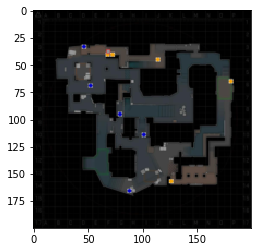

In [ ]:
plt.imshow(key_images[0])

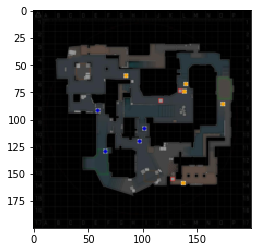

In [ ]:
plt.imshow(key_images[1])

In [ ]:
label_batch

tensor([[1],
        [0]])

In [ ]:
cont_names = ['t_1', 't_2', 't_3', 't_4', 't_5',
              'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5',
              "t_1_blindtime", "t_2_blindtime", "t_3_blindtime", "t_4_blindtime", "t_5_blindtime",
              "ct_1_blindtime", "ct_2_blindtime", "ct_3_blindtime", "ct_4_blindtime", "ct_5_blindtime",
              "t_1_armor", "t_2_armor", "t_3_armor", "t_4_armor", "t_5_armor",
              "ct_1_armor", "ct_2_armor", "ct_3_armor", "ct_4_armor", "ct_5_armor", "round_time"]
cat_names = ["t_1_mainweapon", "t_1_secweapon", "t_1_flashbangs", "t_1_hassmoke", "t_1_hasmolotov", "t_1_hashe",
             "t_1_hashelmet", "t_1_hasc4",
             "t_2_mainweapon", "t_2_secweapon", "t_2_flashbangs", "t_2_hassmoke", "t_2_hasmolotov", "t_2_hashe",
             "t_2_hashelmet", "t_2_hasc4",
             "t_3_mainweapon", "t_3_secweapon", "t_3_flashbangs", "t_3_hassmoke", "t_3_hasmolotov", "t_3_hashe",
             "t_3_hashelmet", "t_3_hasc4",
             "t_4_mainweapon", "t_4_secweapon", "t_4_flashbangs", "t_4_hassmoke", "t_4_hasmolotov", "t_4_hashe",
             "t_4_hashelmet", "t_4_hasc4",
             "t_5_mainweapon", "t_5_secweapon", "t_5_flashbangs", "t_5_hassmoke", "t_5_hasmolotov", "t_5_hashe",
             "t_5_hashelmet", "t_5_hasc4",
             "ct_1_mainweapon", "ct_1_secweapon", "ct_1_flashbangs", "ct_1_hassmoke", "ct_1_hasmolotov", "ct_1_hashe",
             "ct_1_hashelmet", "ct_1_hasdefusekit",
             "ct_2_mainweapon", "ct_2_secweapon", "ct_2_flashbangs", "ct_2_hassmoke", "ct_2_hasmolotov", "ct_2_hashe",
             "ct_2_hashelmet", "ct_2_hasdefusekit",
             "ct_3_mainweapon", "ct_3_secweapon", "ct_3_flashbangs", "ct_3_hassmoke", "ct_3_hasmolotov", "ct_3_hashe",
             "ct_3_hashelmet", "ct_3_hasdefusekit",
             "ct_4_mainweapon", "ct_4_secweapon", "ct_4_flashbangs", "ct_4_hassmoke", "ct_4_hasmolotov", "ct_4_hashe",
             "ct_4_hashelmet", "ct_4_hasdefusekit",
             "ct_5_mainweapon", "ct_5_secweapon", "ct_5_flashbangs", "ct_5_hassmoke", "ct_5_hasmolotov", "ct_5_hashe",
             "ct_5_hashelmet", "ct_5_hasdefusekit"]


def emb_sz_rule(n_cat):
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat ** 0.56))


# # Cell
# def _one_emb_sz(classes, n, sz_dict=None):
#     "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
#     sz_dict = ifnone(sz_dict, {})
#     n_cat = len(classes[n])
#     sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
#     return n_cat,sz
#
# # Cell
# def get_emb_sz(to, sz_dict=None):
#     "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
#     return [_one_emb_sz(to.classes, n, sz_dict) for n in to.cat_names]

class LinBnDrop(torch.nn.Sequential):
    "Module grouping `BatchNorm1d`, `Dropout` and `Linear` layers"

    def __init__(self, n_in, n_out, bn=True, p=0., act=None, lin_first=False):
        layers = [torch.nn.BatchNorm1d(n_in)] if bn else []
        if p != 0: layers.append(torch.nn.Dropout(p))
        lin = [torch.nn.Linear(n_in, n_out, bias=not bn)]
        if act is not None: lin.append(act)
        layers = lin + layers if lin_first else layers + lin
        super().__init__(*layers)


class TabularModelCustom(torch.nn.Module):
    "Basic model for tabular data."

    def __init__(self, category_list, class_groups_sizes, n_cont, layers, ps=None, embed_p=0.,
                 use_bn=True, bn_final=False, bn_cont=True):

        super().__init__()
        ps = ps

        class_group_map = {}
        for i, cat in enumerate(category_list):
            class_group = cat[cat.rfind("_") + 1:]
            class_group_index, _ = class_groups_sizes[class_group]
            if class_group_index in class_group_map:
                class_group_map[class_group_index].append(i)
            else:
                class_group_map[class_group_index] = [i]
        self.class_group_map = class_group_map
        self.embeds = torch.nn.ModuleList(
            [torch.nn.Embedding(index_ni[1], emb_sz_rule(index_ni[1])) for _, index_ni in class_groups_sizes.items() if
             index_ni[1] > 2])
        self.emb_drop = torch.nn.Dropout(embed_p)
        self.bn_cont = torch.nn.BatchNorm1d(n_cont) if bn_cont else None

        binary_size = sum(len(class_group_map[i]) for i in range(len(self.embeds), len(class_group_map)))
        n_emb = sum(e.embedding_dim * len(class_group_map[i]) for i, e in enumerate(self.embeds)) + binary_size
        self.n_emb, self.n_cont = n_emb, n_cont
        sizes = [n_emb + n_cont] + layers
        actns = [torch.nn.ReLU(inplace=True) for _ in range(len(sizes) - 2)]
        _layers = [LinBnDrop(sizes[i], sizes[i + 1], bn=use_bn and (i != len(actns) - 1 or bn_final), p=p, act=a)
                   for i, (p, a) in enumerate(zip(ps, actns))]

        self.layers = torch.nn.Sequential(*_layers)

    def forward(self, x_cat, x_cont=None):

        if self.n_emb != 0:
            x_cat_binary = []
            for i in range(len(self.embeds), len(self.class_group_map)):
                x_cat_binary += self.class_group_map[i]
            with torch.no_grad():
                x_cat_binary = x_cat[:, x_cat_binary].float()
            x_cat_nonbinary = [torch.flatten(e(x_cat[:, self.class_group_map[i]]), start_dim=1) for i, e in
                               enumerate(self.embeds)]
            x = torch.cat(x_cat_nonbinary + [x_cat_binary], 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        return self.layers(x)


group_count = 0
category_groups_sizes = {}
for class_group, class_group_categories in x_category_map.items():
    category_groups_sizes[class_group] = (group_count, len(class_group_categories))
    group_count += 1
category_list = [category for category in x_category_map]
tab_model = TabularModelCustom(category_list, category_groups_sizes, len(cont_names), [200, 100], ps=[0.2, 0.2])


class CustomMixedModel(torch.nn.Module):
    def __init__(self, image_model, tab_model, seq_model):
        super(CustomMixedModel, self).__init__()
        self.image_model = image_model
        # embedding types are primaries, secondaries, flashbangs and binaries
        # self.classifier = TabularModel_NoCat(emb_sizes,1536, 30,[400],ps=[0.1],use_bn=False)
        self.tab_model = tab_model
        # n_emb = sum(e.embedding_dim for e in self.embeds)
        self.seq_model = seq_model
        self.classifier = torch.nn.Sequential(LinBnDrop(200 + image_output_size#+embeds_size
                                                        , 2, act=None, p=0.))

    def forward(self, input_cat, input_cont, input_image,attention_mask):
        with torch.no_grad():
            input_embed=torch.stack([torch.cat((self.tab_model(input_cat[:, i, :], input_cont[:, i, :]),
                                               self.image_model(input_image[:, i,:, :, :])),dim=1)
                                    for i in range(input_cat.shape[1])],dim=1)

        #bert_out = torch.mean(self.seq_model(input_embed.permute((1,0,2)),src_key_padding_mask=attention_mask).permute((1,0,2)),dim=1)

        mask_size=torch.sum((attention_mask==True),dim=1)
        #output = torch.sigmoid(self.classifier(torch.cat((input_embed[range(input_embed.shape[0]),(input_embed.shape[1]-mask_size-1)],bert_out),dim=1)))
        output = torch.sigmoid(self.classifier(input_embed[range(input_embed.shape[0]), (input_embed.shape[1] - mask_size - 1)]))
        return output

In [ ]:
image_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=False,num_classes=image_output_size)
image_model.to("cuda:0")

# configuration = BertConfig(hidden_size=image_output_size+tabular_output_size,
#                            num_attention_heads=num_attention_heads,intermediate_size=intermediate_size,hidden_dropout_prob=0.2,
#                                  attention_probs_dropout_prob=0.2,output_hidden_states=True)
#
# class_model = BertModel(configuration)

encoder_layer = torch.nn.TransformerEncoderLayer(d_model=image_output_size+tabular_output_size, nhead=4)
seq_model = torch.nn.TransformerEncoder(encoder_layer, num_layers=4)
# configuration = DistilBertConfig(dim=tabular_output_size+image_output_size,
#                            n_heads=num_attention_heads,hidden_dim=intermediate_size,dropout=0.2,sinusoidal_pos_embds=True,
#                                  attention_dropout=0.2)
#
# class_model = DistilBertForSequenceClassification(configuration)

seq_model.to("cuda:0")

In [ ]:
image_model.load_state_dict(torch.load(os.path.expanduser('~/projetos/data/csgo_analyze/processed_test/image_output-200.pt')))
tab_model.load_state_dict(torch.load(os.path.expanduser('~/projetos/data/csgo_analyze/processed_test/tabular_output-200.pt')))

model = CustomMixedModel(image_model, tab_model, seq_model)
model = model.to("cuda:0")

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def one_epoch(loss_fn, model, train_data_loader, valid_data_loader, optimizer, tensorboard_class):
    model.train()
    valid_loss = AverageMeter('Loss', ':.4e')
    valid_accuracy = AverageMeter('Acc', ':6.2f')
    for t, batch in enumerate(train_data_loader):

        x_input = batch[:-1]
        y = batch[-1]

        y = y.cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(*[x_tensor.cuda() for x_tensor in x_input])

        # Compute and print loss.
        loss = loss_fn(y_pred, torch.flatten(y))
        if t % 10 == 0:
            print(t, "/", len(train_data_loader), loss.item())

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        # scheduler.step()

    model.eval()
    for t, batch in enumerate(valid_data_loader):

        x_input = batch[:-1]
        y = batch[-1]
        # Forward pass: compute predicted y by passing x to the model.
        y = y.cuda()
        with torch.no_grad():
            y_pred = model(*[x_tensor.cuda() for x_tensor in x_input])

            # Compute and print loss.
            loss = loss_fn(y_pred, torch.flatten(y))
            if t % 10 == 0:
                print(t, "/", len(valid_data_loader), loss.item())
            acc = accuracy(y_pred, y)
            valid_accuracy.update(acc[0].item(), y.shape[0])
            valid_loss.update(loss.item(), y.shape[0])

    print(' * Acc {valid_accuracy.avg:.3f} Loss {valid_loss.avg:.3f}'
          .format(valid_accuracy=valid_accuracy, valid_loss=valid_loss))
    tensorboard_class.writer.add_scalar("loss:",
                                        valid_loss.avg, tensorboard_class.i)
    tensorboard_class.writer.add_scalar("accuracy:",
                                        valid_accuracy.avg, tensorboard_class.i)
    tensorboard_class.i += 1


loss_fn = torch.nn.CrossEntropyLoss().cuda()
breakpoint()
lr_sequence = [5e-4, 5e-5, 5e-7]
n_epochs = 2

now = datetime.datetime.now()
creation_time = now.strftime("%H:%M")
tensorboard_writer = SummaryWriter(os.path.expanduser('~/projetos/data/csgo_analyze/experiment/tensorboard/') +
                                   now.strftime("%Y-%m-%d-") + creation_time)


class TensorboardClass():
    def __init__(self, writer):
        self.i = 0
        self.writer = writer


tensorboard_class = TensorboardClass(tensorboard_writer)
# torch.set_num_threads(8)
for lr in lr_sequence:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        one_epoch(loss_fn, model, train_dl_mixed, valid_dl_mixed, optimizer, tensorboard_class)
